In [20]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def combine_data(files_list, column, start_date, end_date):
    idx = pd.date_range(start_date, end_date, freq='5T')
    data_comb = pd.DataFrame(index=idx)
    for file in files_list:
        try:
            local_data = pd.read_csv(os.path.join(
                DATA_FOLDER, file), delimiter=';', parse_dates=['timestamp'], index_col=5)
            local_data = local_data[[column]]
            local_data = local_data[start_date:].resample('5T').mean()
            local_data = local_data.reindex(idx, fill_value=None)
            data_comb[file] = local_data[column]
        except (pd.errors.ParserError, pd.errors.EmptyDataError,
                pd.core.groupby.groupby.DataError, KeyError) as e:
            print(str(e), file)
    return data_comb

In [3]:
DATA_FOLDER = '../DATA/raw/sensors/'
files = os.listdir(DATA_FOLDER)
sds_files = [i for i in files if 'sds011' in i]
bme_files = [i for i in files if 'bme280' in i]
dht_files = [i for i in files if 'dht22' in i]

In [4]:
with open('../processing_lists/sensorID_list.txt', 'r') as sensors:
    sensor_list = sensors.read().splitlines()
    indoor_sensors = [i for i in sensor_list if 'indoor' in i]

In [5]:
sds_files = [i for i in sds_files if i.split('_')[0] not in indoor_sensors]
bme_files = [i for i in bme_files if i.split('_')[0] not in indoor_sensors]
dht_files = [i for i in dht_files if i.split('_')[0] not in indoor_sensors]

In [6]:
data = pd.read_csv(os.path.join(
    DATA_FOLDER, '26717_bme280_sensor_.csv'), delimiter=';', parse_dates=['timestamp'], index_col=5)
data.head()

,sensor_id,sensor_type,location,lat,lon,pressure,altitude,pressure_sealevel,temperature,humidity
timestamp,,,,,,,,,,
2019-05-27 18:12:41,26717,BME280,14325,55.684,37.584,99031.29,NaN,NaN,18.46,43.94
2019-05-27 18:15:22,26717,BME280,14325,55.684,37.584,99037.25,NaN,NaN,18.39,44.21
2019-05-27 18:17:56,26717,BME280,14325,55.684,37.584,99032.41,NaN,NaN,18.33,44.31
2019-05-27 18:20:30,26717,BME280,14325,55.684,37.584,99032.87,NaN,NaN,18.35,44.31
2019-05-27 18:23:03,26717,BME280,14325,55.684,37.584,99031.01,NaN,NaN,18.33,44.49


In [7]:
p1_data = combine_data(sds_files, 'P1', '2019-04-01', '2020-04-25')
p2_data = combine_data(sds_files, 'P2', '2019-04-01', '2020-04-25')
pressure_data = combine_data(bme_files, 'pressure', '2019-04-01', '2020-04-25')
temperature_data = combine_data(bme_files, 'temperature', '2019-04-01', '2020-04-25')
humidity_data = combine_data(bme_files, 'humidity', '2019-04-01', '2020-04-25')

No columns to parse from file 34369_sds011_sensor_.csv
No columns to parse from file 37791_sds0113_sensor_.csv
'2019-04-01' 29128_sds011_sensor_.csv
'2019-04-01' 32487_sds011_sensor_.csv


//home/anatoly/HDD/anaconda3/envs/mlforair/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


No numeric types to aggregate 24026_sds011_sensor_.csv
No columns to parse from file 26716_sds011_sensor_.csv
No columns to parse from file 34369_sds011_sensor_.csv
No columns to parse from file 37791_sds0113_sensor_.csv
'2019-04-01' 29128_sds011_sensor_.csv
'2019-04-01' 32487_sds011_sensor_.csv
No numeric types to aggregate 24026_sds011_sensor_.csv
No columns to parse from file 26716_sds011_sensor_.csv
No columns to parse from file 34370_bme280_sensor_.csv
No columns to parse from file 34370_bme280_sensor_.csv
No columns to parse from file 34370_bme280_sensor_.csv


In [9]:
def filtred_average(row):
    data = row.values[~np.isnan(row.values)]
    q10 = np.quantile(data, q=0.1)
    q90 = np.quantile(data, q=0.9)
    data = data[data < q90]
    data = data[data > q10]
    return data.mean()

In [10]:
def calc_percentiles(data, name):
    result = pd.DataFrame(index=data.index)
    result[name+'_p10'] = data.quantile(q=0.1, axis=1)
    result[name+'_p25'] = data.quantile(q=0.25, axis=1)
    result[name+'_p50'] = data.quantile(q=0.5, axis=1)
    result[name+'_p75'] = data.quantile(q=0.75, axis=1)
    result[name+'_p90'] = data.quantile(q=0.9, axis=1)
    result[name+'_mean'] = data.mean(axis=1)
    result[name+'_filtr_mean'] = data.dropna(how='all').apply(filtred_average, axis=1)
    return result

In [11]:
p1_statistic = calc_percentiles(p1_data, 'PM2.5')
p2_statistic = calc_percentiles(p2_data, 'PM10')
pressure_statistic = calc_percentiles(pressure_data, 'press')
temp_statistic = calc_percentiles(temperature_data, 'temp')
humidity_statistic = calc_percentiles(humidity_data, 'hum')

//home/anatoly/HDD/anaconda3/envs/mlforair/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
//home/anatoly/HDD/anaconda3/envs/mlforair/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


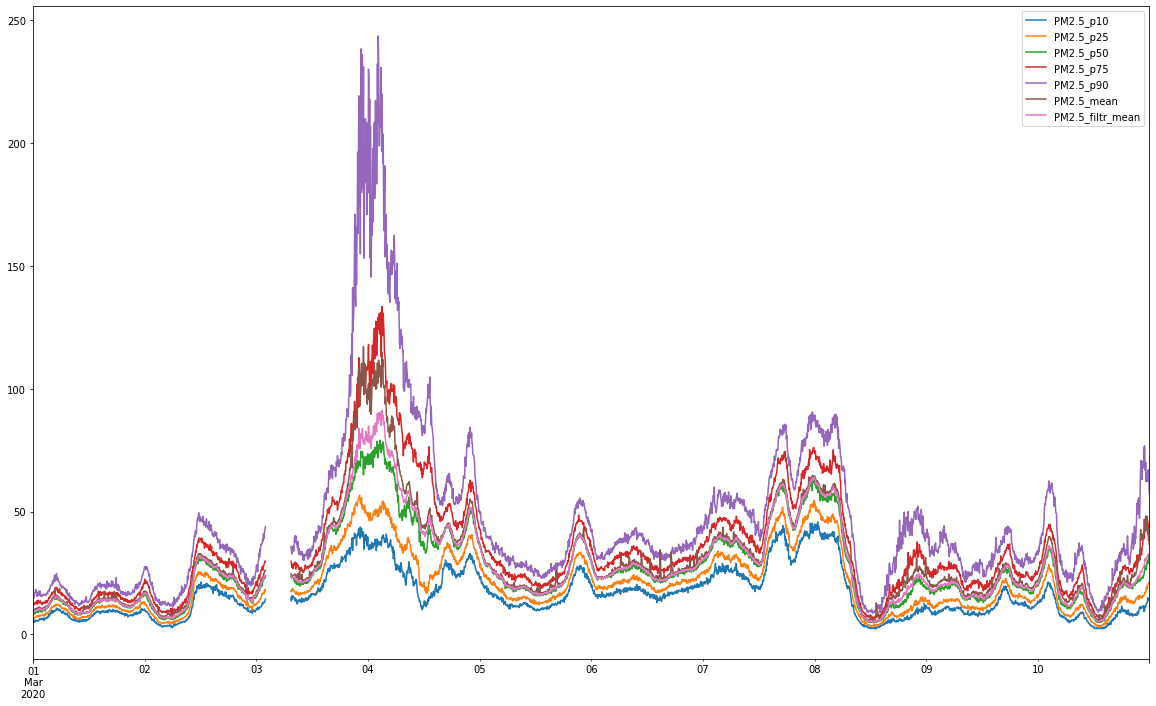

In [28]:
p1_statistic['2020-03-01':'2020-03-10'].plot(figsize=(20, 12))

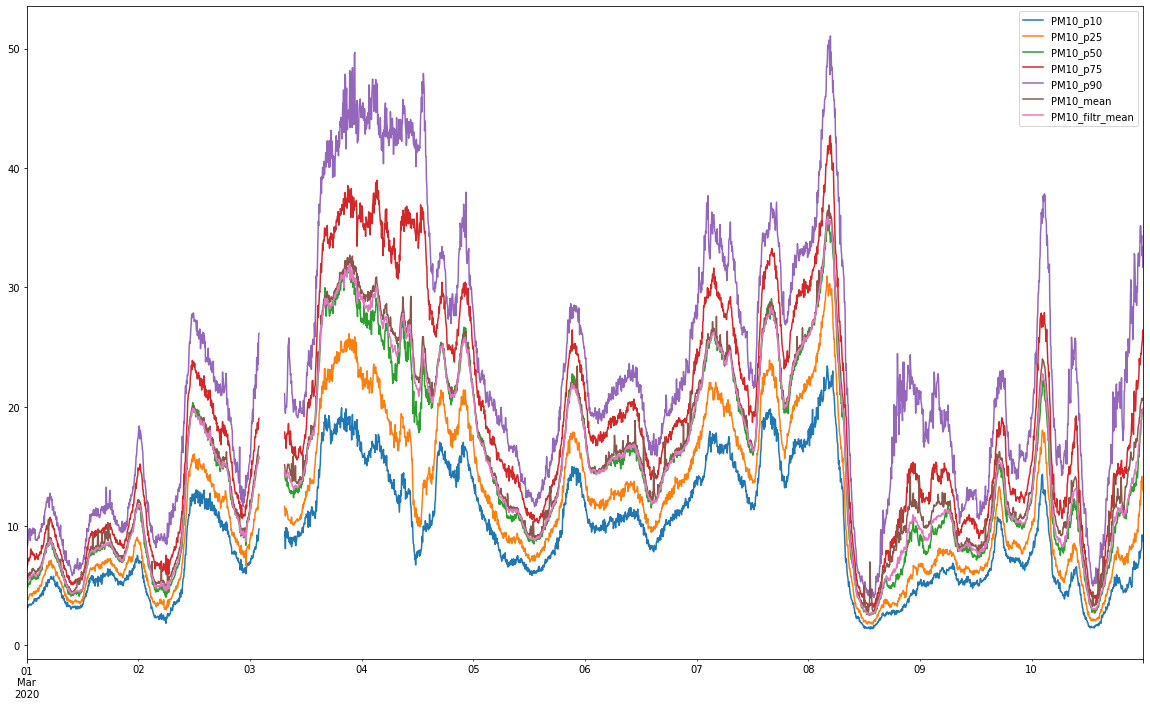

In [29]:
p2_statistic['2020-03-01':'2020-03-10'].plot(figsize=(20, 12))

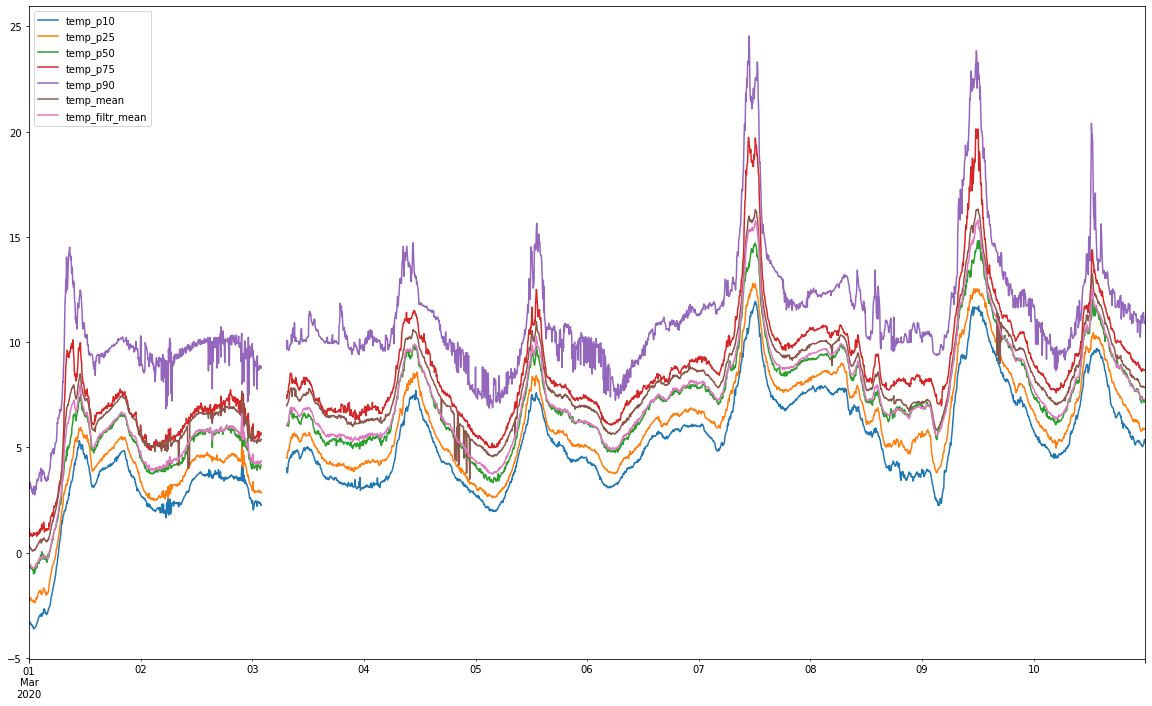

In [30]:
temp_statistic['2020-03-01':'2020-03-10'].plot(figsize=(20, 12))

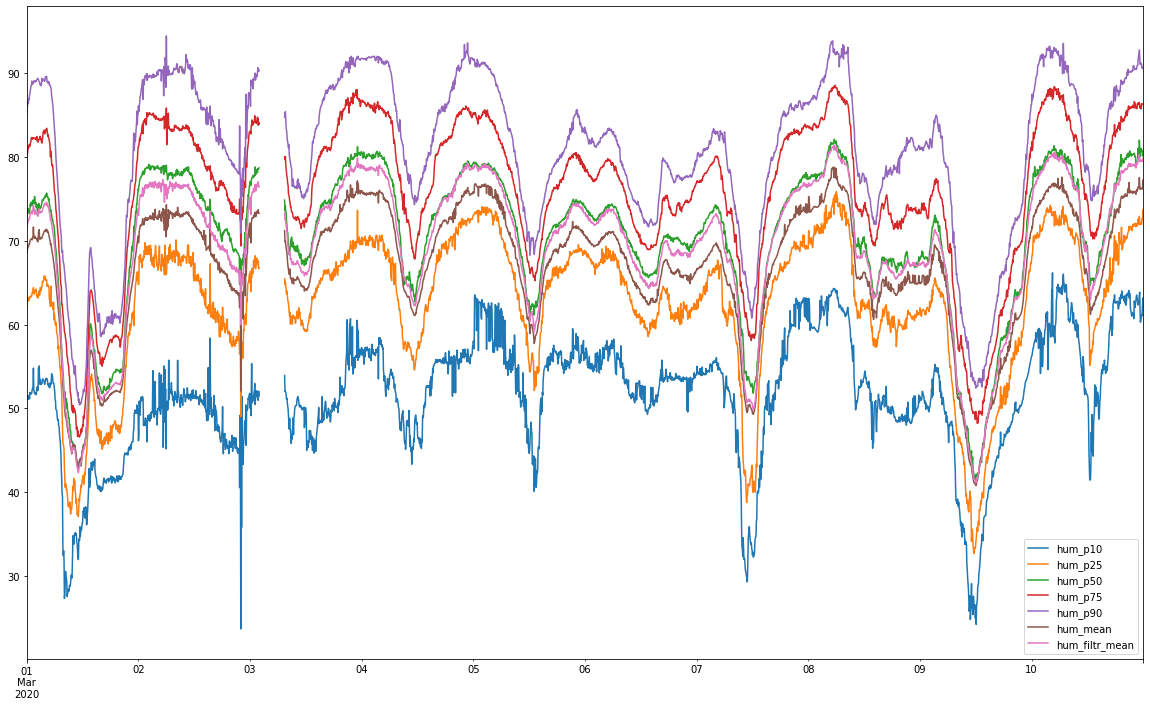

In [31]:
humidity_statistic['2020-03-01':'2020-03-10'].plot(figsize=(20, 12))

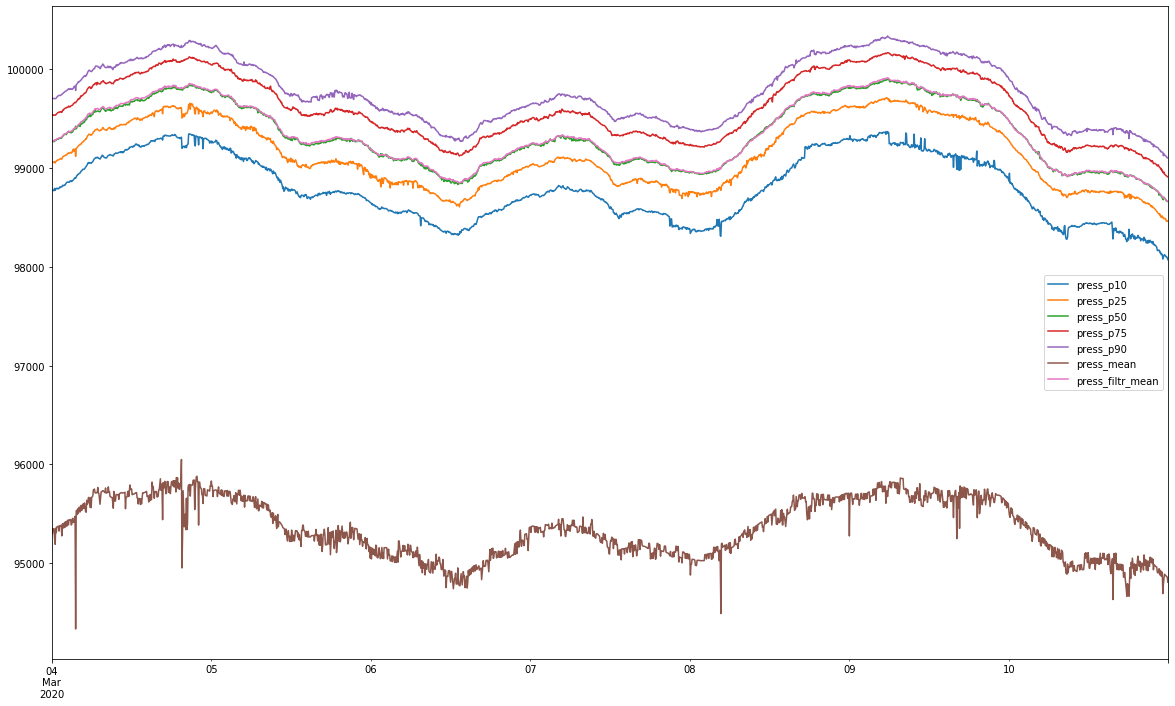

In [33]:
pressure_statistic['2020-03-04':'2020-03-10'].plot(figsize=(20, 12))

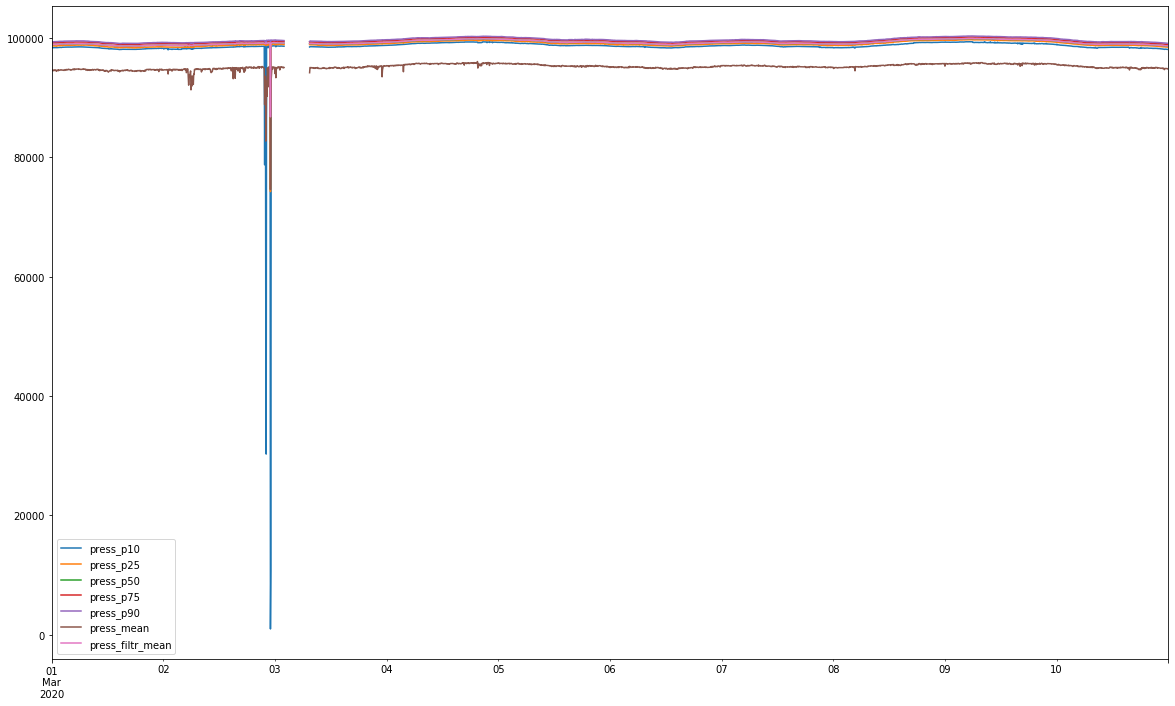

In [34]:
pressure_statistic['2020-03-01':'2020-03-10'].plot(figsize=(20, 12))